In [109]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import r2_score, mean_absolute_error
from scipy.spatial.distance import cdist
import joblib
import seaborn as sns

In [110]:
data = pd.read_csv('cleaned_property_data.csv')

In [111]:
categorical_features = ['TYPE', 'ZIPCODE', 'BOROUGH']
numeric_features = ['BEDS', 'BATH', 'PROPERTYSQFT', 'LATITUDE', 'LONGITUDE']

X = data[categorical_features + numeric_features]
y = data['PRICE']

In [112]:
# Create preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

In [113]:
# Create a pipeline with preprocessor and model
rf_model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

In [114]:
# Split the data and train the model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  ['BEDS', 'BATH',
                                                   'PROPERTYSQFT', 'LATITUDE',
                                                   'LONGITUDE']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['TYPE', 'ZIPCODE',
                                                   'BOROUGH'])])),
                ('regressor', RandomForestRegressor(random_state=42))])

In [115]:
# Calculate performance metrics
y_train_pred = rf_model.predict(X_train)
y_test_pred = rf_model.predict(X_test)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

# Calculate MAE as a percentage
avg_train_price = y_train.mean()
avg_test_price = y_test.mean()
train_mae_percent = (train_mae / avg_train_price) * 100
test_mae_percent = (test_mae / avg_test_price) * 100

print("Model Performance:")
print(f"Training R2 Score: {train_r2:.4f}")
print(f"Testing R2 Score: {test_r2:.4f}")
print(f"Training MAE: ${train_mae:,.2f} ({train_mae_percent:.2f}%)")
print(f"Testing MAE: ${test_mae:,.2f} ({test_mae_percent:.2f}%)")

Model Performance:
Training R2 Score: 0.9678
Testing R2 Score: 0.6773
Training MAE: $69,150.76 (7.73%)
Testing MAE: $208,789.67 (23.13%)


In [116]:
# Save the model
joblib.dump(rf_model, 'rf_model.joblib')

['rf_model.joblib']

In [117]:
# Cross-Validation Scores
cv_scores = cross_val_score(rf_model, X, y, cv=5, scoring='r2')
print(f"Cross-Validation R2 Scores: {cv_scores}")
print(f"Mean CV R2 Score: {np.mean(cv_scores)}")

Cross-Validation R2 Scores: [0.67322593 0.75327821 0.7347727  0.76183574 0.74209874]
Mean CV R2 Score: 0.7330422646040985


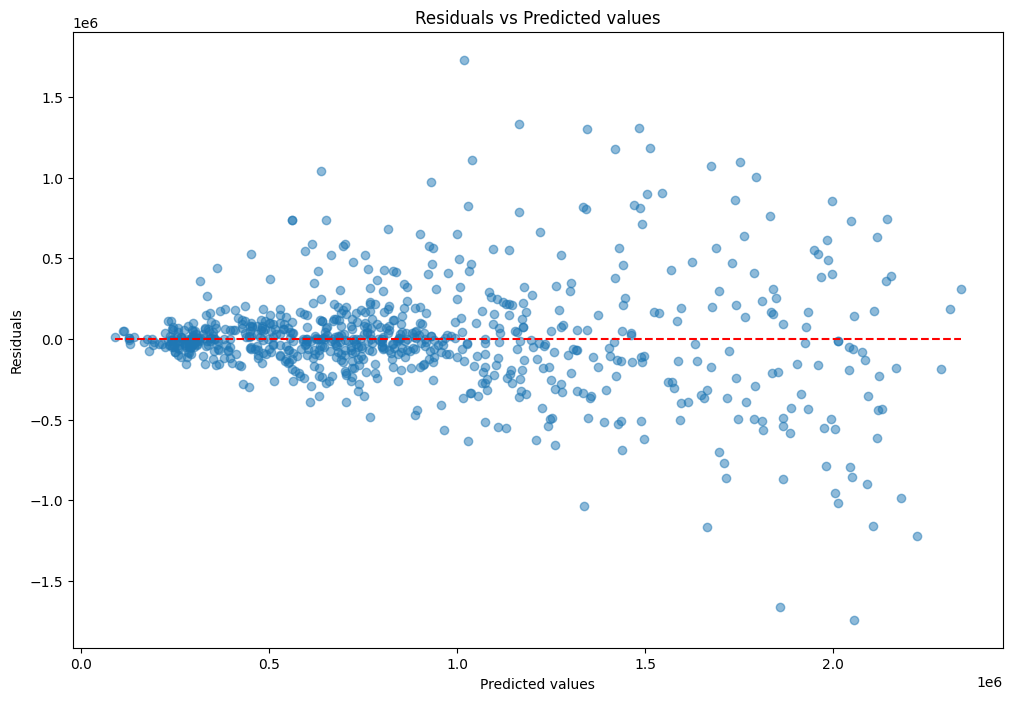

In [118]:
# Calculate residuals
residuals = y_test - y_test_pred

# Plot residuals vs predicted values
plt.figure(figsize=(12, 8))
plt.scatter(y_test_pred, residuals, alpha=0.5)
plt.hlines(y=0, xmin=y_test_pred.min(), xmax=y_test_pred.max(), colors='red', linestyles='dashed')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted values')
plt.show()

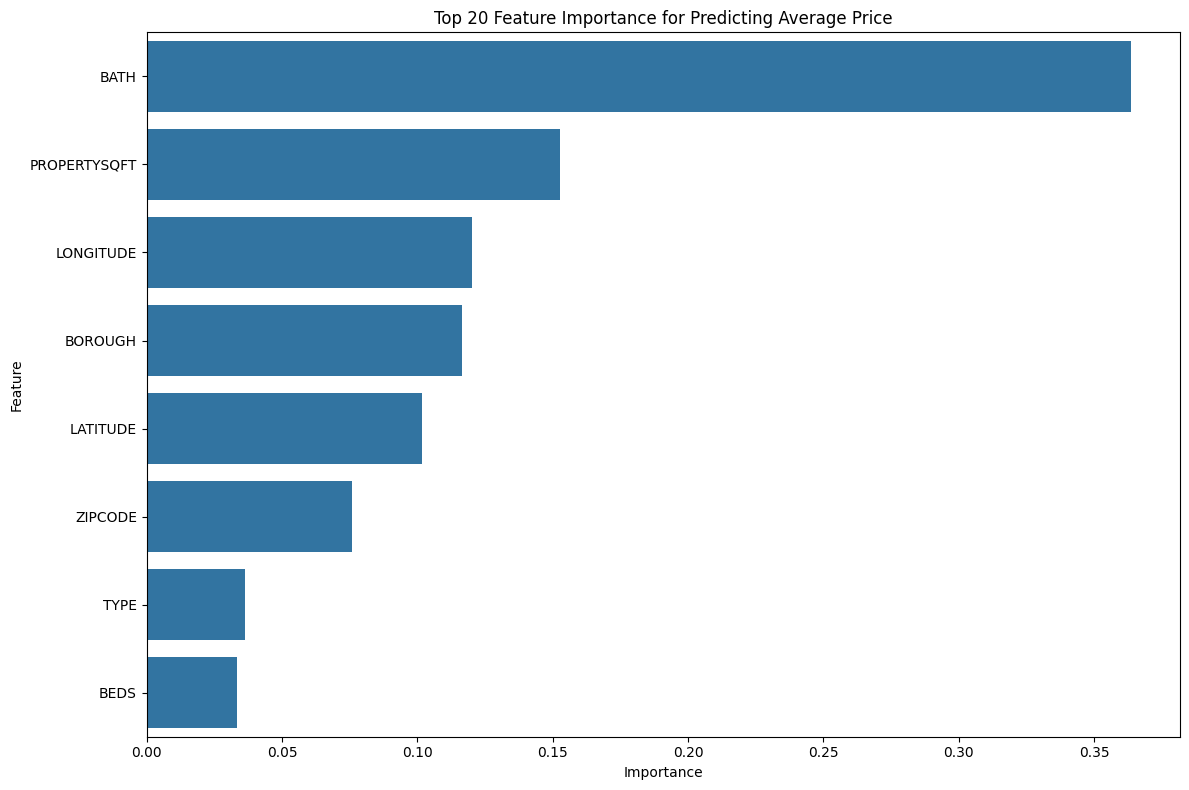

In [119]:
# Get feature names
numeric_features_names = numeric_features
categorical_features_names = fitted_preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
feature_names = np.array(numeric_features_names + list(categorical_features_names))

# Get feature importances from the random forest model
importances = rf_model.named_steps['regressor'].feature_importances_

# Aggregate importances for categorical variables
feature_importance = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importance['feature'] = feature_importance['feature'].apply(lambda x: x.split('_')[0] if '_' in x else x)
feature_importance = feature_importance.groupby('feature').sum().reset_index()
feature_importance = feature_importance.sort_values(by='importance', ascending=False)

# Plot top 20 feature importances
top_n = 20
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importance.head(top_n))
plt.title('Top 20 Feature Importance for Predicting Average Price')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [121]:
# Print feature importances
print("Feature Importances:")
print(feature_importance)

Feature Importances:
        feature  importance
0          BATH    0.363513
5  PROPERTYSQFT    0.152513
4     LONGITUDE    0.120080
2       BOROUGH    0.116617
3      LATITUDE    0.101727
7       ZIPCODE    0.076005
6          TYPE    0.036338
1          BEDS    0.033208


In [120]:
from sklearn.linear_model import LinearRegression

baseline_model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

baseline_model.fit(X_train, y_train)
y_test_baseline_pred = baseline_model.predict(X_test)
baseline_r2 = r2_score(y_test, y_test_baseline_pred)
print(f"Baseline Linear Regression R2 Score: {baseline_r2:.4f}")


Baseline Linear Regression R2 Score: 0.5926
